# Прогнозирование временных рядов

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.stats as stats
from statsmodels.tsa import api as tsa
from statsmodels.tsa.arima_model import ARIMA 
%matplotlib inline

## Исходные данные

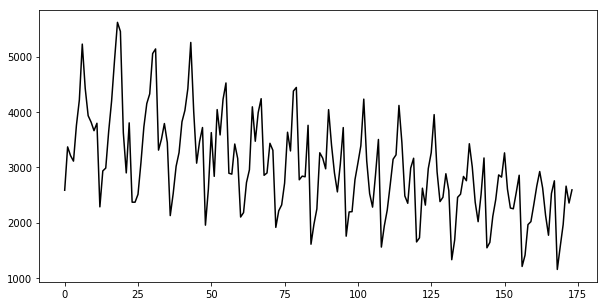

In [3]:
file = h5py.File('LR8_materials/Fort.mat', 'r')
data = file.get('Fort')
Fort = np.array(data)
plt.figure(figsize = (10, 5)) 
plt.plot(Fort, 'k')
plt.show()

Вид ВР представлен на рисунке ниже. На глаз, в ряде видна явная сезонность, присутствует некоторый убывающий тренд.

## Ретросперктивный прогноз

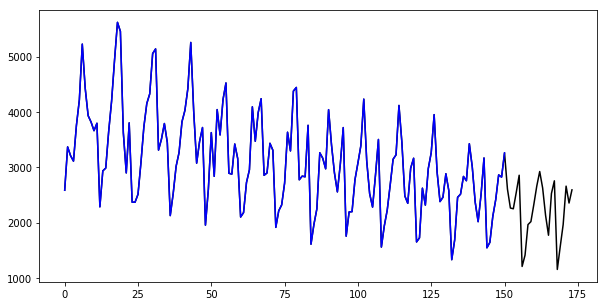

In [4]:
Z = Fort[:len(Fort)-24+1] # отрезаем последние 24 точки 
t = np.arange(0, len(Z), 1) # временная шкала для регрессии t=t.reshape(-1,1)
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k') # исходный ВР 
plt.plot(t, Z, 'b') # урезанный ряд 
plt.show()

### 5. Простейшие методы прогноза на основе ЛР3

#### 11. Оцените точность каждого из получившихся прогнозов с помощью следующих оценок (где M – число прогнозируемых точек):

In [96]:
from math import sqrt

M = 24

In [115]:
def SPO(X_init, Z_init, M):
    """Средняя ошибка прогноза
    
    Args:
        X_init - original data
        Z_init - predicted data
        M - number predicted dots
    Returns:
        Средняя ошибка прогноза
    """
    X = X_init[-M:]
    Z = Z_init[-M:]
    
    sumDelta = 0
    
    for i in range(0, M):
        sumDelta += float(abs(X[i] - Z[i]))
    return sumDelta / M

In [116]:
def SKPO(X_init, Z_init, M):
    """СКВО прогноза
    
    Args:
        X_init - original data
        Z_init - predicted data
        M - number predicted dots
    Returns:
        СКВО прогноза
    """
    X = X_init[-M:]
    Z = Z_init[-M:]
    
    sumDelta = 0
    
    for i in range(0, M):
        sumDelta += float(abs(X[i] - Z[i])**2)
    return sqrt(sumDelta / M)

In [117]:
def SAO(X_init, Z_init, M):
    """Средняя ошибка аппроксимации
    
    Args:
        X_init - original data
        Z_init - predicted data
        M - number predicted dots
    Returns:
        Средняя ошибка аппроксимации
    """
    X = X_init[-M:]
    Z = Z_init[-M:]
    
    sumDelta = 0
    
    for i in range(0, M):
        sumDelta += float(abs(X[i] - Z[i])/X[i])
    return sumDelta / M

In [118]:
def KN1(X_init, Z_init, M):
    """Коэффициент несоответствия 1
    
    Args:
        X_init - original data
        Z_init - predicted data
        M - number predicted dots
    Returns:
        Коэффициент несоответствия 1
    """
    X = X_init[-M:]
    Z = Z_init[-M:]
    
    sumDeltaTop = 0
    for i in range(0, M):
        sumDeltaTop += float((X[i] - Z[i])**2)
        
    sumDeltaBottom = 0
    for i in range(0, M):
        sumDeltaBottom += float(Z[i]**2)
        
    return sqrt(sumDeltaTop / sumDeltaBottom)

In [346]:
import numpy as np
def KN2(X_init, Z_init, M):
    """Коэффициент несоответствия 2
    
    Args:
        X_init - original data
        Z_init - predicted data
        M - number predicted dots
    Returns:
        Коэффициент несоответствия 2
    """
    X = X_init[-M:]
    Z = Z_init[-M:]
    sumDeltaTop = 0
    for i in range(0, M):
        sumDeltaTop += float((X[i] - Z[i])**2)
    
    averageZ = np.mean(Z)
    sumDeltaBottom = 0
    for i in range(0, M):
        sumDeltaBottom += float((averageZ - Z[i])**2)
        
    return sqrt(sumDeltaTop / sumDeltaBottom)

In [122]:
def summarize_errors(X, Z, M):
    print(f"Средняя ошибка прогноза: {SPO(X, Z, M)}")
    print(f"СКВО прогноза: {SKPO(X, Z, M)}")
    print(f"Средняя ошибка аппроксимации: {SAO(X, Z, M)}")
    print(f"Коэффициент несоответствия 1: {KN1(X, Z, M)}")
    print(f"Коэффициент несоответствия 2: {KN2(X, Z, M)}")
    

#### 13. Постройте доверительные интервалы для тренда второго и третьего порядка на рисунке вместе с прогнозом и самим рядом, используя более простые эмпирические оценки:

In [147]:
def intervalCoeff(X_init, Z_init, M):
    """доверительные интервалы для тренда
    
    Args:
        X_init - original data
        Z_init - predicted data
        M - number predicted dots
    Returns:
        доверительные интервалы для тренда
    """
    X = X_init[-M:]
    Z = Z_init[-M:]
    
    sumDelta = 0
    
    for i in range(0, M):
        sumDelta += float((X[i] - Z[i])**2) 
        
    return 1.96 * sqrt(sumDelta / M)

#### прогноза по методу регрессии с помощью sklearn

1 порядок

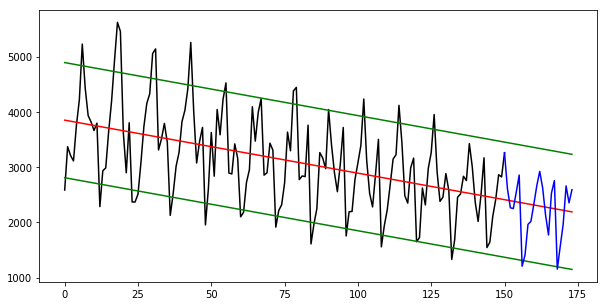

In [155]:
t=np.arange(0, len(Z), 1) # диапазон урезанного ряда
t=t.reshape(-1,1)
t0=np.arange(0, len(Fort), 1) # диапазон полного ряда 
t0=t0.reshape(-1,1)

from sklearn.linear_model import LinearRegression 
reg = LinearRegression().fit(t, Z) # модель регрессии 

intervalConst = intervalCoeff(Fort, reg.predict(t0), M)

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k')
plt.plot(t0, reg.predict(t0) - intervalConst, 'g') # доверительный интервал 
plt.plot(t0, reg.predict(t0), 'r') # прогноз на весь диапазон 
plt.plot(t0, reg.predict(t0) + intervalConst, 'g') # доверительный интервал  
plt.plot(t0[-24:], Fort[-24:], 'b') # реальные прогнозные значения 
plt.show()

In [124]:
summarize_errors(Fort, reg.predict(t0), M)

Средняя ошибка прогноза: 437.01727779714184
СКВО прогноза: 531.284134980843
Средняя ошибка аппроксимации: 0.23514412988159802
Коэффициент несоответствия 1: 0.23084331650074877
Коэффициент несоответствия 2: 8.003642309615843


2 порядок

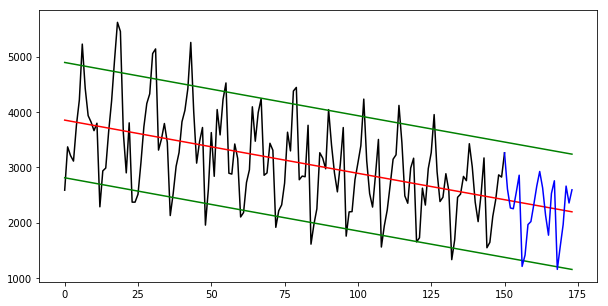

In [157]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

yfit = reg.predict(t0)
model = make_pipeline(PolynomialFeatures(2), Ridge())
model.fit(yfit.reshape(-1, 1)[:-23], Z)
y_plot = model.predict(yfit.reshape(-1, 1))

intervalConst = intervalCoeff(Fort, y_plot, M)

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k')
plt.plot(t0, y_plot - intervalConst, 'g') # прогноз на весь диапазон 
plt.plot(t0, y_plot, 'r') # прогноз на весь диапазон 
plt.plot(t0, y_plot + intervalConst, 'g') # прогноз на весь диапазон 
plt.plot(t0[-24:], Fort[-24:], 'b') # реальные прогнозные значения 
plt.show()

In [126]:
summarize_errors(Fort, y_plot, M)

Средняя ошибка прогноза: 436.6989982325522
СКВО прогноза: 531.5136365357685
Средняя ошибка аппроксимации: 0.23533399008242642
Коэффициент несоответствия 1: 0.23062294525799326
Коэффициент несоответствия 2: 8.090450852055412


3 порядок

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.235219e-23
  overwrite_a=True).T


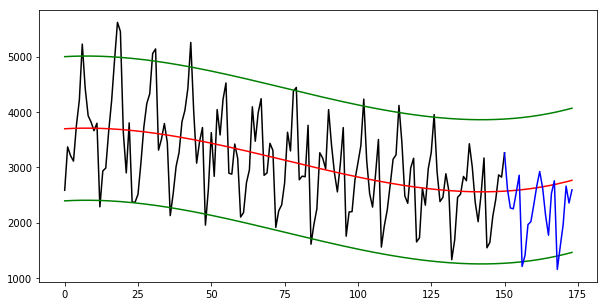

In [158]:
yfit = reg.predict(t0)
model = make_pipeline(PolynomialFeatures(3), Ridge())
model.fit(yfit.reshape(-1, 1)[:-23], Z)
y_plot = model.predict(yfit.reshape(-1, 1))

intervalConst = intervalCoeff(Fort, y_plot, M)

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k')
plt.plot(t0, y_plot - intervalConst, 'g')
plt.plot(t0, y_plot, 'r') # прогноз на весь диапазон 
plt.plot(t0, y_plot + intervalConst, 'g')
plt.plot(t0[-24:], Fort[-24:], 'b') # реальные прогнозные значения 
plt.show()

In [128]:
summarize_errors(Fort, y_plot, M)

Средняя ошибка прогноза: 493.75953488074873
СКВО прогноза: 664.6292477210105
Средняя ошибка аппроксимации: 0.29285345849074823
Коэффициент несоответствия 1: 0.2511325859301679
Коэффициент несоответствия 2: 11.145195828739805


#### Напрямую через МНК библиотеки statsmodels

[3849.23884629   -9.58949808]


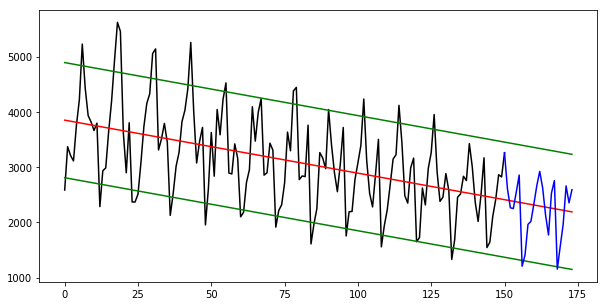

In [159]:
import statsmodels.api as sm
x_ = sm.add_constant(t)
smm = sm.OLS(Z, x_)
res = smm.fit() # строим модель регрессии 

intervalConst = intervalCoeff(Fort, res.predict(sm.add_constant(t0)), M)

print(res.params)
plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k')
plt.plot(t0, res.predict(sm.add_constant(t0)) - intervalConst, 'g')
plt.plot(t0, res.predict(sm.add_constant(t0)), 'r') # строим прогноз 
plt.plot(t0, res.predict(sm.add_constant(t0)) + intervalConst, 'g')
plt.plot(t0[-24:], Fort[-24:], 'b') # реальные прогнозные значения 
plt.show()

In [130]:
summarize_errors(Fort, res.predict(sm.add_constant(t0)), M)

Средняя ошибка прогноза: 437.01727779714173
СКВО прогноза: 531.2841349808433
Средняя ошибка аппроксимации: 0.23514412988159827
Коэффициент несоответствия 1: 0.23084331650074852
Коэффициент несоответствия 2: 8.003642309615845


#### Через полиномиальные кривые polyfit:

1 degree

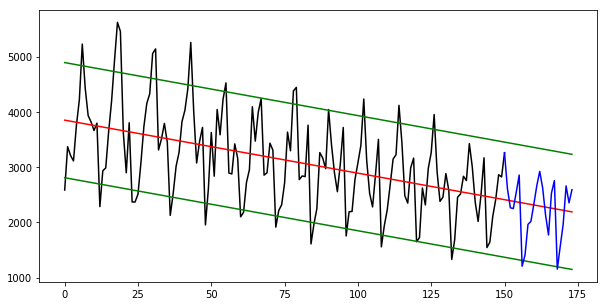

In [160]:
bb = np.polyfit(t.reshape(1,-1)[0], Z.reshape(1,-1)[0], 1)
p = np.poly1d(bb) # создаем экземпляр полинома 

intervalConst = intervalCoeff(Fort, p(t0), M)

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k')
plt.plot(t0, p(t0) - intervalConst, 'g')
plt.plot(t0, p(t0), 'r') # полином на прогнозной временной сетке 
plt.plot(t0, p(t0) + intervalConst, 'g')
plt.plot(t0[-24:], Fort[-24:], 'b')
plt.show()

In [132]:
summarize_errors(Fort, p(t0), M)

Средняя ошибка прогноза: 437.017277797142
СКВО прогноза: 531.2841349808431
Средняя ошибка аппроксимации: 0.23514412988159802
Коэффициент несоответствия 1: 0.23084331650074874
Коэффициент несоответствия 2: 8.003642309615833


2 degree

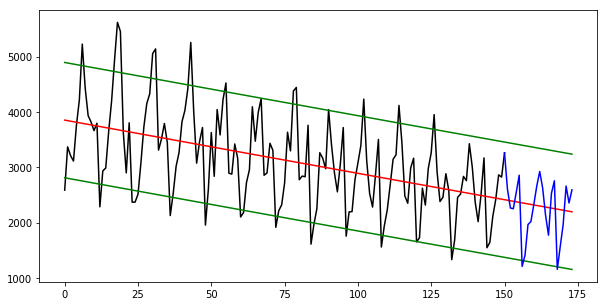

In [162]:
bb2 = np.polyfit(t.reshape(1,-1)[0], Z.reshape(1,-1)[0], 2)
T2_polyfit = bb2[2]+(bb2[1])*t0+(bb2[0])*(t0**2)

intervalConst = intervalCoeff(Fort, T2_polyfit, M)

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k')
plt.plot(t0, T2_polyfit - intervalConst, 'g')
plt.plot(t0, T2_polyfit, 'r') # полином на прогнозной временной сетке 
plt.plot(t0, T2_polyfit + intervalConst, 'g')
plt.plot(t0[-24:], Fort[-24:], 'b')
plt.show()

In [134]:
summarize_errors(Fort, T2_polyfit, M)

Средняя ошибка прогноза: 436.6990845412035
СКВО прогноза: 531.5135713865609
Средняя ошибка аппроксимации: 0.2353339382848848
Коэффициент несоответствия 1: 0.23062300399838107
Коэффициент несоответствия 2: 8.090427433558819


3 degree

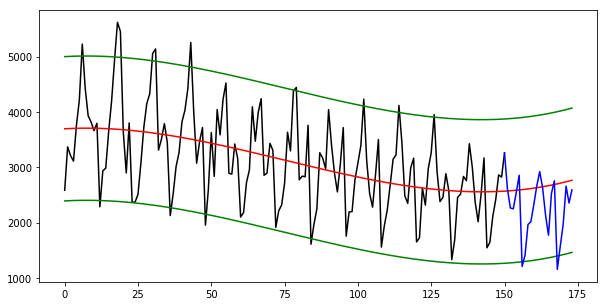

In [163]:
bb3 = np.polyfit(t.reshape(1,-1)[0], Z.reshape(1,-1)[0], 3)
T3_polyfit = bb3[3]+bb3[2]*t0+bb3[1]*t0**2+bb3[0]*t0**3

intervalConst = intervalCoeff(Fort, T3_polyfit, M)

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k')
plt.plot(t0, T3_polyfit - intervalConst, 'g')
plt.plot(t0, T3_polyfit, 'r') # полином на прогнозной временной сетке 
plt.plot(t0, T3_polyfit + intervalConst , 'g')
plt.plot(t0[-24:], Fort[-24:], 'b')
plt.show()

In [136]:
summarize_errors(Fort, T3_polyfit, M)

Средняя ошибка прогноза: 494.11283726484794
СКВО прогноза: 665.0082914257578
Средняя ошибка аппроксимации: 0.2930517639635935
Коэффициент несоответствия 1: 0.25121922124671875
Коэффициент несоответствия 2: 11.11230145732954


#### Через подгонку функций библиотеки scipy.optimize

1 degree

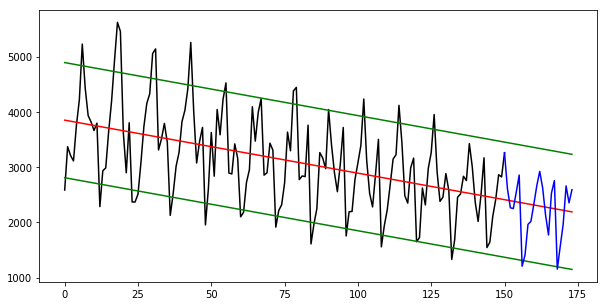

In [348]:
def func(t, b0, b1):
    return b0 + b1 * t
from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, t.reshape(1,-1)[0], Z.reshape(1,-1)[0]) 

intervalConst = intervalCoeff(Fort, t0*popt[1]+popt[0], M)

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k')
plt.plot(t0, t0*popt[1]+popt[0] - intervalConst, 'g')
plt.plot(t0, t0*popt[1]+popt[0], 'r')
plt.plot(t0, t0*popt[1]+popt[0] + intervalConst, 'g')
plt.plot(t0[-24:], Fort[-24:], 'b')
plt.show()

In [349]:
summarize_errors(Fort, t0*popt[1]+popt[0], M)

Средняя ошибка прогноза: 437.01727779676395
СКВО прогноза: 531.2841349811363
Средняя ошибка аппроксимации: 0.2351441298819064
Коэффициент несоответствия 1: 0.23084331650040818
Коэффициент несоответствия 2: 8.003642309600977


2 degree

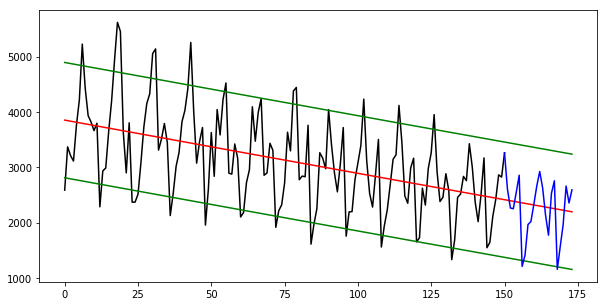

In [166]:
def func_2(t, b0, b1, b2):
    return b0 + b1 * t + b2 * t**2
popt_2, pcov = curve_fit(func_2, t.reshape(1,-1)[0], Z.reshape(1,-1)[0])

intervalConst = intervalCoeff(Fort, func_2(t0, *popt_2), M)

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k')
plt.plot(t0, func_2(t0, *popt_2) - intervalConst, 'g')
plt.plot(t0, func_2(t0, *popt_2), 'r')
plt.plot(t0, func_2(t0, *popt_2) + intervalConst, 'g')
plt.plot(t0[-24:], Fort[-24:], 'b')
plt.show()

In [140]:
summarize_errors(Fort, func_2(t0, *popt_2), M)

Средняя ошибка прогноза: 436.69908454591604
СКВО прогноза: 531.51357138277
Средняя ошибка аппроксимации: 0.2353339382816084
Коэффициент несоответствия 1: 0.2306230040019553
Коэффициент несоответствия 2: 8.090427432881095


3 degree

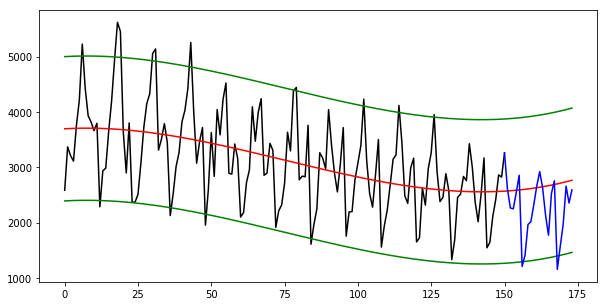

In [167]:
def func_3(t, b0, b1, b2, b3):
    return b0 + b1 * t + b2 * t**2 + b3*t**3
popt_3, pcov = curve_fit(func_3, t.reshape(1,-1)[0], Z.reshape(1,-1)[0])

intervalConst = intervalCoeff(Fort, func_3(t0, *popt_3), M)

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k')
plt.plot(t0, func_3(t0, *popt_3) - intervalConst, 'g')
plt.plot(t0, func_3(t0, *popt_3), 'r')
plt.plot(t0, func_3(t0, *popt_3) + intervalConst, 'g')
plt.plot(t0[-24:], Fort[-24:], 'b')
plt.show()

In [142]:
summarize_errors(Fort, func_3(t0, *popt_3), M)

Средняя ошибка прогноза: 494.11283229413465
СКВО прогноза: 665.0082858768127
Средняя ошибка аппроксимации: 0.293051761072894
Коэффициент несоответствия 1: 0.25121922003430947
Коэффициент несоответствия 2: 11.112301583150417


## АРПСС модели

### 15. постройте линейный тренд прогнозируемого ряда (см. линейную регрессию первого порядка выше), а затем вычтите его из исходного ряда, приведя его к нулевому среднему значению (к так называемой тренд- стационарной форме).

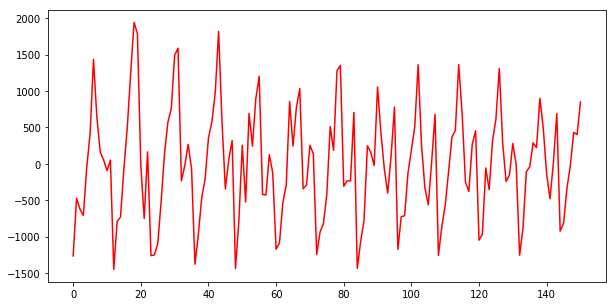

In [326]:
def func(t, b0, b1):
    return b0 + b1 * t
from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, t.reshape(1,-1)[0], Z.reshape(1,-1)[0]) 

stationaryTrand = Fort[:-23] - (t0*popt[1]+popt[0])[:-23]
stationaryFunc = Fort - (t0*popt[1]+popt[0])
# stationaryTrand = Fort - (t0*popt[1]+popt[0])

plt.figure(figsize = (10, 5))
plt.plot(t, stationaryTrand, 'r')
plt.show()

In [323]:
p, d, q = [9, 0, 5]

arimaz = ARIMA(stationaryTrand, order = (p, d, q)) 
model_fit = arimaz.fit(disp = False) # подгоняем под ВР 
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  151
Model:                     ARMA(9, 5)   Log Likelihood               -1115.546
Method:                       css-mle   S.D. of innovations            378.897
Date:                Mon, 20 May 2019   AIC                           2263.091
Time:                        19:08:39   BIC                           2311.367
Sample:                             0   HQIC                          2282.703
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5411     16.208      0.342      0.733     -26.226      37.308
ar.L1.y        0.6735      0.266      2.528      0.013       0.151       1.196
ar.L2.y       -0.7301      0.338     -2.162      0.0

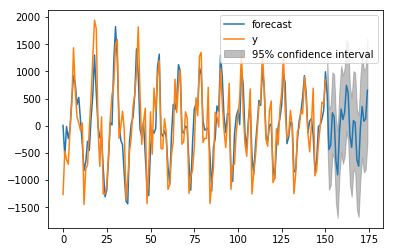

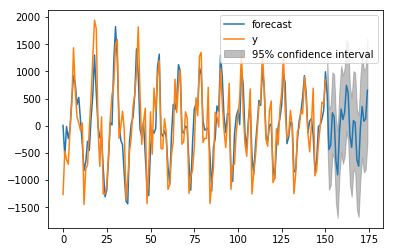

In [324]:
model_fit.plot_predict(0, len(Fort))

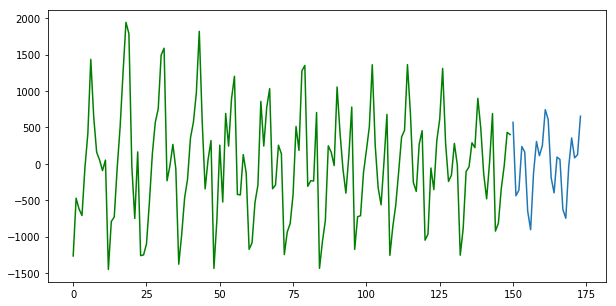

In [335]:
intervalConst = intervalCoeff(Fort, (t0*popt[1]+popt[0]), M)


plt.figure(figsize = (10, 5))
# model_fit.plot_predict(1, len(Fort)) # прогноз по АРПСС
plt.plot(t0[:-24], stationaryFunc[:-24], 'g')
plt.plot(t0[-24:], model_fit.predict(1, len(Fort))[-24:])
plt.show()

<Figure size 720x360 with 0 Axes>

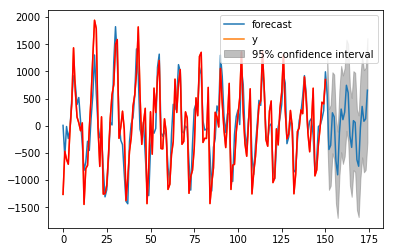

In [225]:
plt.figure(figsize = (10, 5))
model_fit.plot_predict(0, len(Fort)) # прогноз по АРПСС
plt.plot(t, stationaryTrand, 'r') # исходный ВР минус тренд 
plt.show()

In [336]:
summarize_errors(stationaryFunc, model_fit.predict(0, len(Fort)), M)

Средняя ошибка прогноза: 433.18049065823146
СКВО прогноза: 525.3219791967342
Средняя ошибка аппроксимации: 0.5973994025164958
Коэффициент несоответствия 1: 1.1744554193724177
Коэффициент несоответствия 2: 1.1745260551060668


### Наконец, попробуйте построить АРПСС модель для прогнозирования данного ряда, но без исходного вычитания из него линейного тренда.

In [342]:
p, d, q = [6,1,7]

arimaz = ARIMA(Z, order = (p, d, q)) 
model_fit = arimaz.fit(disp = False) # подгоняем под ВР 
print(model_fit.summary())

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  150
Model:                 ARIMA(6, 1, 7)   Log Likelihood               -1119.655
Method:                       css-mle   S.D. of innovations            394.838
Date:                Mon, 20 May 2019   AIC                           2269.309
Time:                        19:40:27   BIC                           2314.469
Sample:                             1   HQIC                          2287.656
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.9677      0.688    -14.480      0.000     -11.317      -8.618
ar.L1.D.y     -0.0460      0.034     -1.352      0.178      -0.113       0.021
ar.L2.D.y      0.1548      0.031      4.957      0.0

<Figure size 720x360 with 0 Axes>

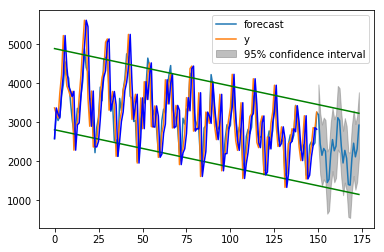

In [344]:
intervalConst = intervalCoeff(Fort, (t0*popt[1]+popt[0]), M)

plt.figure(figsize = (10, 5))
model_fit.plot_predict(1, len(Fort)) # прогноз по АРПСС
# plt.plot(t0[-24:], model_fit.predict(1, len(Fort))[-24:])
plt.plot(t0, (t0*popt[1]+popt[0]) - intervalConst, 'g')
plt.plot(t0[:-24], Fort[:-24], 'b')
plt.plot(t0, (t0*popt[1]+popt[0]) + intervalConst, 'g')
plt.show()

In [347]:
summarize_errors(Fort, model_fit.predict(1, len(Fort)), M)

Средняя ошибка прогноза: 2280.5012583454723
СКВО прогноза: 2428.7170150039933
Средняя ошибка аппроксимации: 0.9823604768047131
Коэффициент несоответствия 1: 5.3667500927776
Коэффициент несоответствия 2: 5.369289939388711
